In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
import sys
import folium
import folium
import pickle
import geopy.exc
import functools
import numpy as np
import pandas as pd
import seaborn as sns
from psmpy import PsmPy
import missingno as msno
from pathlib import Path
from folium import plugins
from fuzzywuzzy import fuzz
import plotly.express as px
from functools import wraps
import statsmodels.api as sm
from esda.moran import Moran
from kneed import KneeLocator
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from psmpy.functions import cohenD
from gap_statistic import OptimalK
from sklearn.cluster import KMeans
from libpysal.weights import lat2W
from scipy.sparse import csr_matrix
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import matplotlib.patches as mpatches
from geopy.geocoders import Nominatim
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import kpss
from deep_translator import GoogleTranslator
from sklearn.preprocessing import StandardScaler


colors_dict = {0: '#DC37B8', 1: '#37B6CE', 2: '#FFC840', 3: '#CDF93E'}

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)

In [3]:
def rewrite_pkl(path_to_file, what_to_dump):
    open(path_to_file, "w").close()
    with open(path_to_file, "wb") as fp:
        pickle.dump(what_to_dump, fp)


def gen_cache(dict_name):
    def decorate(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            global dict_

            try:
                dict_[f'{func.__name__}']
            except (NameError, KeyError):
                dict_ = {}

                try:
                    with open(dict_name, 'rb') as file:
                        dict_[f'{func.__name__}'] = pickle.load(file)
                except (FileNotFoundError, EOFError):
                    rewrite_pkl(dict_name, {})
                    dict_[f'{func.__name__}'] = {}

            all_args = f'{args} {kwargs.keys()} {kwargs.values()}'

            if all_args not in dict_[f'{func.__name__}']:
                dict_[f'{func.__name__}'][all_args] = func(*args, **kwargs)
                rewrite_pkl(dict_name, dict_[f'{func.__name__}'])

            return dict_[f'{func.__name__}'][all_args]
        return wrapper
    return decorate


nomin = Nominatim(user_agent="GetLoc")


@gen_cache(f'cache/cache_translator.pkl')
def translator(x, source='russian', target='english'):
    if not x:
        return x
    return GoogleTranslator(source=source, target=target).translate(x)


@gen_cache(f'cache/cache_get_state.pkl')
def get_state(location):
    global nomin

    try:
        location = nomin.reverse(location)
        return location.raw['address']['state']
    except KeyError:
        return None
    except geopy.exc.GeocoderServiceError:
        get_state(location)

        
@gen_cache(f'cache/cache_get_geocode.pkl')
def get_geocode(location):
    global nomin

    try:
        return nomin.geocode(location)[1]
    except geopy.exc.GeocoderServiceError:
        get_geocode(location)

# I. PREPROCESSING OF DROM.RU

In [160]:
path = '../data/dataframes/final/'


files = Path(path).glob('*.tsv')

df = pd.concat([pd.read_csv(f, sep='\t', header=0) for f in files], ignore_index=True)


df = df.drop(['num_of_views', 'date_of_parsing', 'report', 'url'], axis=1)\
    .drop_duplicates()\
    .reset_index(drop=True)\
    .drop(['brand_model_rus', 'estimate_of_the_model',
           'estimate_of_price', 'location', 'city_ad', 'city_from_title',
           'generation', 'configuration', 'notes'], 
          axis=1)


print(df.shape)
print(round(sys.getsizeof(df) / (1024 ** 3), 3))

(987440, 22)
0.909


In [161]:
df = df[
    (~df[['engine_liters', 'power', 'gearbox', 'drive']].isna().any(axis=1)) &
    ((~df['mileage'].isna()) | df['mileage_new_car'])
]\
    .reset_index(drop=True)

df['mileage'] = df['mileage'].fillna(0)

df['date_of_ad'] = pd.to_datetime(df['date_of_ad'], format='%d.%m.%Y')
df = df[df['date_of_ad'].between('2022-10-24', '2022-12-31')]


print(df.shape)

(817599, 22)


In [162]:
df['state_rus'] = df.apply(lambda x: get_state(f"{x['location_latitude']},{x['location_longitude']}"), axis=1)
df.loc[df['state_rus'] == 'Ханты-Мансийский автономный округ — Югра', 'state_rus'] = 'Тюменская область'

df['state'] = df['state_rus'].apply(lambda x: translator(x))
df['state'] = df['state'].apply(lambda x: x.lower() if x else x)

df = df[df['state'].notna()].reset_index(drop=True)

df['state_location'] = df['state_rus'].apply(lambda x: get_geocode(x + '- центр'))
df['state_latitude'] = df['state_location'].apply(lambda x: x[0])
df['state_longitude'] = df['state_location'].apply(lambda x: x[1])

In [163]:
df.to_csv('data_spatial/df_preprossed.tsv', encoding='utf-8', sep='\t', index=False)

# II. ANALYSIS OF DROM.RU

In [96]:
df = pd.read_csv('data_spatial/df_preprossed.tsv', sep='\t', header=0)

### PIVOT TABLES

In [20]:
def cars_pivot(df, by:list, val_counts:list, values:list, counts_min = 0, asc = False):
    assert len(by) == len(val_counts)

    df = df.fillna(0)

    for i in range(len(by)):
        condition = (df[by[i]].value_counts() > val_counts[i])
        l = [*condition.index[condition]]
        df = df[df[by[i]].isin(l)]

    aggfunc = {}
    if 'price' in values:
        aggfunc['price'] = lambda x: round(x.astype('int').mean() / 1000)
    if 'mileage' in values:
        aggfunc['mileage'] = lambda x: round(x.mean())
    if 'year_of_car' in values:
        aggfunc['year_of_car'] = lambda x: round(x.mean())

    pivot = df.pivot_table(
        values = values,
        index = by,
        aggfunc = aggfunc)\
        .sort_values(values, ascending = asc)\
        .join(df.groupby(by).size().rename('Counts'))\
        .rename({'price': 'Avg. price (k, rub)',
                 'mileage': 'Avg. mileage (km)',
                 'year_of_car': 'Avg. Release year'}, axis = 1)

    pivot = pivot[pivot['Counts'] > counts_min]
    
    return pivot

In [ ]:
# cars_pivot(df = df, by = ['city'], val_counts = [1000], values = ['price'])
# cars_pivot(df = df, by = ['city'], val_counts = [1000], values = ['mileage'])
# cars_pivot(df = df, by = ['brand_model'], val_counts = [30], values = ['price'])
# cars_pivot(df = df, by = ['brand'], val_counts = [100], values = ['price'])
# cars_pivot(df = df, by = ['brand'], val_counts = [100], values = ['mileage'])
# cars_pivot(df = df, by = ['city', 'brand_model'], val_counts = [1000, 10], values = ['price'], counts_min = 5)
cars_pivot(df = df, by = ['brand_model', 'city'], val_counts = [1, 1000], values = ['price'], counts_min = 1)

### MISSINGNO MATRIX

In [4]:
plt.rc('figure', dpi = 250)

fig = msno.matrix(df, width_ratios = [300, 100], sparkline = False, p = 0, fontsize = 18)
gray_patch = mpatches.Patch(color = 'gray', label = 'Есть информация')
white_patch = mpatches.Patch(color = 'white', label = 'Нет информации')

plt.legend(handles = [gray_patch, white_patch], fontsize = 24)

fig.get_figure().savefig('images/missingno.png', bbox_inches = 'tight')

# fig.show()

In [97]:
df['body_type'] = df.groupby('brand_model')['body_type'].fillna(method='ffill').fillna(method='bfill')
df['wheel'] = df.groupby('brand_model')['wheel'].fillna(method='ffill').fillna(method='bfill')

df = df[~df[['body_type', 'wheel']].isna().any(axis=1)].reset_index(drop=True)

### Unique by _

In [98]:
brand_model_counts = df['brand_model'].value_counts()
valid_brand_models = brand_model_counts[brand_model_counts >= 100].index

df = df\
    .loc[df['brand_model'].isin(valid_brand_models)]\
    .reset_index(drop=True)

print(df.shape)

(790818, 27)


In [99]:
print(f'Number of unique cities: {len(df["city"].unique())}')
print(f'Number of unique brands: {len(df["brand"].unique())}')
print(f'Number of unique models: {len(df["model"].unique())}')

Number of unique cities: 3216
Number of unique brands: 63
Number of unique models: 732


### HEATMAP OF ALL CARS

In [39]:
m = folium.Map(location = [50, 94],
               zoom_start = 3,
               scrollWheelZoom = False)

stationArr = df[['location_latitude', 'location_longitude']].values

m.add_child(plugins.HeatMap(stationArr, radius = 15))

title_html = f'<h3 align="center" style="font-size:25px"><b>{"HeatMap of all car sale ads on Drom.ru"}</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m.fit_bounds([[40, 25], [60, 165]])
m.save('images/heatmap_of_cars.html')

# m

### CIRCLE MAP

In [ ]:
m = folium.Map(location = [50, 94],
               zoom_start = 3,
               scrollWheelZoom = False)

data_folium = df  # df[df['brand'] == 'Audi']
data_folium = data_folium[['location_latitude', 'location_longitude', 'city']]\
    .value_counts()\
    .reset_index()

for i in range(0, 500):
    folium.Circle(
        location = (data_folium.iloc[i]['location_latitude'], data_folium.iloc[i]['location_longitude']),
        radius = float(data_folium.iloc[i][0]) * 15,  # 300
        tooltip = data_folium.iloc[i]['city'],
        color = '#69b3a2',
        fill = True,
        fill_color = '#69b3a2'
    ).add_to(m)

title_html = f'<h3 align="center" style="font-size:25px"><b>{"CircleMap of all car sale ads on Drom.ru"}</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m.fit_bounds([[40, 25], [60, 165]])
m.save('images/circlemap_of_cars.html')

# m

### STATES

In [100]:
df['state_rus'].value_counts()

Москва                       69105
Приморский край              64377
Новосибирская область        50990
Иркутская область            46306
Тюменская область            44219
                             ...  
Республика Крым                261
Карачаево-Черкесия             201
Севастополь                     96
Калмыкия                        77
Ненецкий автономный округ        3
Name: state_rus, Length: 84, dtype: int64

In [101]:
state_counts = df['state_rus'].value_counts()

state_counts = df['state_rus'].value_counts()
valid_states = state_counts[state_counts >= 1000].index

print(len(valid_states))

df = df\
    .loc[df['state_rus'].isin(valid_states)]\
    .reset_index(drop=True)

print(df.shape)

63
(780365, 27)


### TREEMAP BY SHARE

In [ ]:
fig = px.treemap(df, path = ['brand', 'model'])

fig.update_layout(margin = dict(t = 50, l = 25, r = 25, b = 25),
#                   title = "Brands by market share on Drom.ru",
                  width = 1100,
                  height = 650,
                  title_font_size = 25)
fig.data[0]['textfont']['size'] = 20

fig.write_image("images/brands by market share.png")

# fig.show()

### DRIVE + WHEEL

In [40]:
df_donut = df['drive'].value_counts()
trace_1 = go.Pie(labels = df_donut.index,
                 values = df_donut,
                 hole = .6,
                 textinfo = 'label + percent')

df_donut = df['wheel'].value_counts()
trace_2 = go.Pie(labels = df_donut.index,
                 values = df_donut,
                 hole = .3,
                 textinfo = 'label + percent')

fig = go.Figure(data = [trace_2, trace_1])
fig.data[0].domain = {'x': [0, 1], 'y': [0.25, 0.75]}
fig.update_traces(marker_colors = ['#36D695','#EC3B86','#FF9F40', '#D25FD2', '#4188D2'])

fig.write_image("images/drive + wheel.png")

# fig.show()

### ENGINE

In [4]:
df_donut = df['engine_type'].value_counts()
trace_0 = go.Pie(labels = df_donut.index,
                 values = df_donut,
                 hole = .4,
                 textinfo = 'label + percent')

df_donut = df['engine_hybrid'].value_counts()
trace_1 = go.Pie(labels = ['нет гибрида', 'есть гибрид'],
                 values = df_donut,
                 hole = .4,
                 textinfo = 'label + percent')

df_donut = df['engine_gas_equipment'].value_counts()
trace_2 = go.Pie(labels = ['нет газа', 'есть газ'],
                 values = df_donut,
                 hole = .4,
                 textinfo = 'label + percent')

fig = go.Figure(data = [trace_0, trace_1, trace_2])
fig.data[0].domain = {'x': [0, .33], 'y': [0, 1]}
fig.data[1].domain = {'x': [.33, .66], 'y': [0, 1]}
fig.data[2].domain = {'x': [.66, 1], 'y': [0, 1]}
fig.update_layout(showlegend = False,
#                   title = "Properties of engine of all cars",
                  title_font_size = 25,
                  annotations=[
                      dict(text='Тип', x=0.33 / 2 - 0.02, y=0.5, font_size=16, showarrow=False, font=dict(color="black")),
                      dict(text='Гибрид?', x=(0.33 + 0.66) / 2, y=0.5, font_size=16, showarrow=False,font=dict(color="black")),
                      dict(text='Есть газ?', x=(0.66 + 1) / 2 + 0.04, y=0.5, font_size=16, showarrow=False,font=dict(color="black"))])
fig.update_traces(marker_colors = ['#36D695','#EC3B86','#FF9F40', '#D25FD2', '#4188D2'])

fig.write_image("images/engine.png")

fig.show()

In [108]:
df = df[df['engine_type'] != 'электро'].reset_index(drop=True)

df = df.loc[
    df['engine_liters'].between(
        df['engine_liters'].quantile(0.005), 
        df['engine_liters'].quantile(0.995)
    )
]
print(df.shape)

(776600, 27)


### TREEMAP BY YEAR

In [ ]:
# TREEMAP BY YEAR

df_treemap = cars_pivot(df = df,
                        by = ['brand'],
                        val_counts = [0],
                        values = ['year_of_car'],
                        counts_min = 5)\
    .reset_index()\
    .rename({'Avg. Release year': 'Средний год пр-ва'}, axis=1)

fig = px.treemap(df_treemap,
                 path = [px.Constant('Бренды'), 'brand'],
                 color = 'Средний год пр-ва',
                 # hover_data = ['Counts'],
                 values = 'Counts',
                 color_continuous_scale = 'Viridis',
                 range_color = [min(df_treemap['Средний год пр-ва']), max(df_treemap['Средний год пр-ва'])])

fig.update_traces(root_color = "lightgrey")
fig.update_layout(margin = dict(t = 50, l = 25, r = 25, b = 25),
#                   title = "Brands by market share and average release year on Drom.ru",
                  width = 1100,
                  height = 700,
                  title_font_size = 25)
fig.data[0]['textfont']['size'] = 20

fig.write_image("images/brands_year.png")

# fig.show()

### SCATTERMAP OF BRAND

In [ ]:
brand_to_see = 'Toyota'

data_scatter = df[df['brand'] == brand_to_see]
fig = go.Figure(go.Scattermapbox(lat=data_scatter['location_latitude'], lon=data_scatter['location_longitude']))
map_center = go.layout.mapbox.Center(lat= 66, lon=94)
fig.update_layout(mapbox_style="open-street-map",
                  mapbox=dict(center=map_center, zoom=1.2))

# fig.show()

### BODY TYPE

In [125]:
body_type_counts = df['body_type'].value_counts()
body_type_counts = body_type_counts\
    .reset_index()\
    .rename({'index': 'Тип кузова', 'body_type': 'Количество'}, axis=1)

fig = px.bar(body_type_counts,
             x = 'Тип кузова',
             y = 'Количество')
fig.update_layout(
    autosize=False, 
    width=800, 
    height=400
)

fig.write_image("images/body type.png")

# fig.show()

In [109]:
body_type_counts = df['body_type'].value_counts()
valid_body_types = body_type_counts[body_type_counts >= 3000].index

df = df\
    .loc[df['body_type'].isin(valid_body_types)]\
    .reset_index(drop=True)

print(df.shape)

(772491, 27)


### MILEAGE

In [63]:
mileage_labels = pd.cut(df['mileage'],
                        bins=[1, 85000, 145000, 200000, 999999],
                        labels=['[1k, 85k]', '(85k, 145k]', '(145k, 200k]', '(200k, 1m]']).rename('mileage_labels')

mileage_labels = pd.concat([df, mileage_labels], axis=1).apply(
    lambda row: row['mileage_labels'] if row['mileage_labels'] == row['mileage_labels'] else 'Новая', axis = 1)


df_donut = mileage_labels.value_counts()
trace_0 = go.Pie(labels = df_donut.index,
                 values = df_donut,
                 hole = .5,
                 textinfo = 'label + percent')

df_donut = df['no_mileage_in_RF'].value_counts()
trace_1 = go.Pie(labels = ['есть пробег по РФ', 'нет пробега по РФ'],
                 values = df_donut,
                 hole = .5,
                 textinfo = 'label + percent')

fig = go.Figure(data = [trace_0, trace_1])
fig.data[0].domain = {'x': [0, .5], 'y': [0, 1]}
fig.data[1].domain = {'x': [.5, 1], 'y': [0, 1]}

fig.update_layout(showlegend = False,
                  title = "Properties of engine of all cars",
                  title_font_size = 25,
                  annotations=[
                      dict(text='Mileage', x=0.215, y=0.5, font_size=16, showarrow=False, font=dict(color="black")),
                      dict(text='Mileage in RF', x=0.81, y=0.5, font_size=16, showarrow=False,font=dict(color="black"))])
fig.update_traces(marker_colors = ['#36D695','#EC3B86','#FF9F40', '#D25FD2', '#4188D2'])

fig.write_image("images/mileage.png")

# fig.show()

### First 10 and last 10 brands by average mileage

In [ ]:
piv = cars_pivot(df = df,
                 by = ['brand'],
                 val_counts = [1000],
                 values = ['mileage'],
                 counts_min = 1000,
                 asc = False)
piv = piv.rename({'Avg. mileage (km)': 'Средний пробег, км'}, axis=1).rename_axis('Бренд')

fig = px.bar(piv.reset_index().iloc[[*range(10)] + [*range(piv.shape[0] - 10, piv.shape[0])]],
             x = piv.index.name,
             y = piv.columns[0])

fig.update_layout(title_font_size = 25,     
                  autosize=False, 
                  width=800, 
                  height=400)

fig.write_image("images/brands by mileage.png")

# fig.show()

### First 10 and last 10 cities by average mileage

In [ ]:
piv = cars_pivot(df = df,
                 by = ['city'],
                 val_counts = [1000],
                 values = ['mileage'],
                 counts_min = 1000,
                 asc = True)

piv = piv.rename({'Avg. mileage (km)': 'Средний пробег, км'}, axis=1).rename_axis('Город')


fig = px.bar(piv.reset_index().iloc[[*range(10)] + [*range(piv.shape[0] - 10, piv.shape[0])]],
             x = piv.index.name,
             y = piv.columns[0])

fig.update_layout(title_font_size = 25,     
                  autosize=False, 
                  width=800, 
                  height=400)

fig.write_image("images/brands by mileage.png")

# fig.show()

### DISTRIBUTION OF MILEAGE

In [117]:
import plotly.figure_factory as ff

fig = ff.create_distplot([df['mileage']], 
                         ['Пробег, км.'],
                         show_rug=False,
                         show_hist=False)

fig.update_layout(title_font_size = 25,     
                  autosize=False, 
                  width=800, 
                  height=400)

fig.write_image("images/distribution of mileage.png")

# fig.show()

### MILEAGE THE LINE

In [90]:
window = 10000

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


df = df[['mileage', 'price', 'brand_model']].copy()
df['mileage'] = df['mileage'].fillna(0)
df['price_relative_to_mean'] = df.groupby('brand_model')['price'].transform(lambda x: x/x.mean())
df = df[(df['price_relative_to_mean'] < 5) & (df['price_relative_to_mean'] > 0.2)]

df = df.sort_values('mileage').reset_index(drop=True)

df['mean'] = smooth(df['price_relative_to_mean'], window)

df_pred = df[['mileage', 'mean']].rename(
    {
        'mileage': 'Пробег', 
        'mean': 'Отношение цены к средней цене'
    }, 
    axis=1)


fig = px.line(
    data_frame=df_pred, 
    x='Пробег', 
    y='Отношение цены к средней цене'
)

fig.update_traces(line=dict(color="Black", width=4))

fig.update_layout(
    autosize=False, 
    width=800, 
    height=400
)

fig.write_image("images/price by mileage.png")

# fig.show()

In [112]:
df = df[df['mileage'] <= 400000].reset_index(drop=True)

df[df['price'].between(df['price'].quantile(0.005), df['price'].quantile(0.995))]

print(df.shape)

(762291, 27)


In [113]:
for col in ['no_mileage_in_RF', 'mileage_new_car', 'engine_gas_equipment', 'engine_hybrid']:
    df[col] = df[col].astype('int')

### SAVING!

In [114]:
df = df.loc[~df.isna().any(axis=1)].reset_index(drop=True)

print(df.shape)

df.head()

(746640, 27)


,price,brand_model,brand,model,year_of_car,date_of_ad,city,location_latitude,location_longitude,power,gearbox,drive,color,wheel,body_type,engine_type,engine_gas_equipment,engine_hybrid,engine_liters,mileage,no_mileage_in_RF,mileage_new_car,state_rus,state,state_location,state_latitude,state_longitude
0,3490000,Toyota Land Cruiser Prado,Toyota,Land Cruiser Prado,2017,2022-11-18,Улан-Удэ,51.835784,107.583911,163.0,АКПП,4WD,белый,правый,джип/suv 5 дв.,бензин,0,0,2.7,110000.0,1,0,Бурятия,buryatia,"(50.3545786, 106.450023)",50.354579,106.450023
1,2299000,Chery Tiggo 7 Pro,Chery,Tiggo 7 Pro,2022,2022-11-05,Улан-Удэ,51.835784,107.583911,147.0,вариатор,передний,синий,левый,купе,бензин,0,0,1.5,0.0,0,1,Бурятия,buryatia,"(50.3545786, 106.450023)",50.354579,106.450023
2,1270000,Mitsubishi Outlander,Mitsubishi,Outlander,2014,2022-11-18,Уфа,54.726141,55.947499,146.0,вариатор,4WD,серебристый,левый,лифтбек,бензин,0,0,2.0,158000.0,0,0,Башкортостан,bashkortostan,"(53.522107250000005, 57.68260509553392)",53.522107,57.682605
3,330000,Toyota Vista Ardeo,Toyota,Vista Ardeo,1998,2022-11-18,Улан-Удэ,51.835784,107.583911,145.0,АКПП,передний,зеленый,правый,лифтбек,бензин,0,0,2.0,200000.0,0,0,Бурятия,buryatia,"(50.3545786, 106.450023)",50.354579,106.450023
4,1780000,JAC J7,JAC,J7,2022,2022-11-21,Барнаул,53.347402,83.778450,136.0,механика,передний,белый,левый,лифтбек,бензин,0,0,1.5,0.0,0,1,Алтайский край,altai region,"(53.793338, 81.3524401)",53.793338,81.352440


In [115]:
df.to_csv('data_spatial/df_prepared.tsv', encoding='utf-8', sep='\t', index=False)

# III. REGIONAL INDICATORS

In [116]:
df = pd.read_csv('data_spatial/df_prepared.tsv', sep='\t', header=0)

In [117]:
indicators = pd.read_excel('data_spatial/indicators.xlsx')

for col in ['average_income', 'average_invest_per_capita_5years']:
    indicators[f'log_{col}'] = np.log(indicators[col])
    indicators = indicators.drop(col, axis=1)
    
indicators.head()

,region,population,urban_rate,paved_roads_per_capita,buses_per_capita,log_average_income,log_average_invest_per_capita_5years
0,Белгородская область,1531.9,67.7,13.152130,92,10.480438,11.521486
1,Брянская область,1168.8,70.6,9.806600,136,10.361166,10.927913
2,Владимирская область,1323.7,78.2,8.015544,72,10.257273,11.081860
3,Воронежская область,2287.7,68.1,9.046920,109,10.465956,11.703773
4,Ивановская область,976.9,81.9,7.461079,118,10.263955,10.528259


In [118]:
indicators['region'] = indicators['region'].apply(lambda x: translator(x))
indicators['region'] = indicators['region'].apply(lambda x: x.lower() if x else x)

regions = [*indicators['region']]
sr = {}
for state in df['state'].unique():
    ratios = [fuzz.WRatio(state, region) for region in regions]
    sr[state] = regions[ratios.index(max(ratios))]

rs = {r: s for s, r in sr.items()}

indicators['state'] = indicators['region'].apply(lambda x: rs[x] if x in rs.keys() else None)

indicators = indicators.drop('region', axis=1)

In [119]:
cols = indicators.columns[:-1]

indicators = indicators.rename(columns = dict(zip(cols, 'state_' + cols)))

In [120]:
df = pd.merge(df, indicators, on='state')

print(df.shape)

df.head()

(746640, 33)


,price,brand_model,brand,model,year_of_car,date_of_ad,city,location_latitude,location_longitude,power,gearbox,drive,color,wheel,body_type,engine_type,engine_gas_equipment,engine_hybrid,engine_liters,mileage,no_mileage_in_RF,mileage_new_car,state_rus,state,state_location,state_latitude,state_longitude,state_population,state_urban_rate,state_paved_roads_per_capita,state_buses_per_capita,state_log_average_income,state_log_average_invest_per_capita_5years
0,3490000,Toyota Land Cruiser Prado,Toyota,Land Cruiser Prado,2017,2022-11-18,Улан-Удэ,51.835784,107.583911,163.0,АКПП,4WD,белый,правый,джип/suv 5 дв.,бензин,0,0,2.7,110000.0,1,0,Бурятия,buryatia,"(50.3545786, 106.450023)",50.354579,106.450023,982.6,59.1,9.56783,129,10.251112,11.021178
1,2299000,Chery Tiggo 7 Pro,Chery,Tiggo 7 Pro,2022,2022-11-05,Улан-Удэ,51.835784,107.583911,147.0,вариатор,передний,синий,левый,купе,бензин,0,0,1.5,0.0,0,1,Бурятия,buryatia,"(50.3545786, 106.450023)",50.354579,106.450023,982.6,59.1,9.56783,129,10.251112,11.021178
2,330000,Toyota Vista Ardeo,Toyota,Vista Ardeo,1998,2022-11-18,Улан-Удэ,51.835784,107.583911,145.0,АКПП,передний,зеленый,правый,лифтбек,бензин,0,0,2.0,200000.0,0,0,Бурятия,buryatia,"(50.3545786, 106.450023)",50.354579,106.450023,982.6,59.1,9.56783,129,10.251112,11.021178
3,1750000,Chery Tiggo T11,Chery,Tiggo T11,2021,2022-11-09,Улан-Удэ,51.835784,107.583911,122.0,автомат,передний,серый,левый,седан,бензин,0,0,2.0,14600.0,0,0,Бурятия,buryatia,"(50.3545786, 106.450023)",50.354579,106.450023,982.6,59.1,9.56783,129,10.251112,11.021178
4,830000,Toyota Kluger V,Toyota,Kluger V,2001,2022-11-21,Хоринск,52.161251,109.779640,160.0,АКПП,4WD,серый,правый,джип/suv 5 дв.,бензин,0,0,2.4,369000.0,0,0,Бурятия,buryatia,"(50.3545786, 106.450023)",50.354579,106.450023,982.6,59.1,9.56783,129,10.251112,11.021178


### SAVING!

In [121]:
df.to_csv('data_spatial/df_merged.tsv', encoding='utf-8', sep='\t', index=False)

# III. CLUSTER ANALYSIS

In [122]:
df = pd.read_csv('data_spatial/df_merged.tsv', sep='\t', header=0)

In [123]:
kmeans_kwargs = {
    "init": "k-means++",
    "max_iter": 300,
    "random_state": 42,
}

## 1. SPATIAL

In [124]:
k_range = range(1, 10)

clust_features = np.array(df[['location_latitude', 'location_longitude']])

scaler = StandardScaler()
clust_features = scaler.fit_transform(clust_features)

##### ELBOW CURVE METHOD

In [125]:
# interia = SSE = WWS
sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(clust_features)
    sse.append(kmeans.inertia_)
    
elbow_df = pd.DataFrame({'Количество кластеров': k_range, 'Значение WWS': sse})

In [126]:
kl = KneeLocator(k_range, sse, curve="convex", direction="decreasing")

print(f'NUMBER OF CLUSTERS BY SSE: {kl.elbow}')

NUMBER OF CLUSTERS BY SSE: 4


##### GAP

In [127]:
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')

n_clusters = optimalK(clust_features, cluster_array=k_range)

gap_df = pd.DataFrame({'Количество кластеров': optimalK.gap_df['n_clusters'], 
                       'Значение GAP': optimalK.gap_df['gap_value']})

/home/balabaev/All/stack/venv_ml/lib64/python3.10/site-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


##### GRAPH OF ELBOW CURVE + GAP

In [128]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=list(k_range), y=sse, name="WWS"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=list(k_range), y=optimalK.gap_df['gap_value'], name="GAP"),
    secondary_y=True,
)

fig.update_layout(
    autosize=False, 
    width=800, 
    height=400
)

fig.update_xaxes(title_text="Количество кластеров")
fig.update_yaxes(title_text="Значение WWS", secondary_y=False)
fig.update_yaxes(title_text="Значение GAP", secondary_y=True)

fig.write_image("images/EC + GAP for spatial.png")

# fig.show()

##### BUILDING THE MODEL

In [129]:
kmeans = KMeans(n_clusters=kl.elbow, **kmeans_kwargs)

kmeans.fit(clust_features)

print(f'The lowest SSE value of all init\'s: {kmeans.inertia_:.3f}, with the number of iterations required to converge: {kmeans.n_iter_}')


The lowest SSE value of all init's: 297497.377, with the number of iterations required to converge: 4


In [130]:
clust_centers = scaler.inverse_transform(kmeans.cluster_centers_)

df['spatial_label'] = kmeans.labels_

##### VISUALIZATION

In [134]:
m = folium.Map([56, 85], zoom_start = 4)

df['cluster_color'] = df['spatial_label'].replace(colors_dict)

data_folium = df[['location_latitude', 'location_longitude', 'city', 'cluster_color']].value_counts().reset_index()
n_show = 1000

for i in range(0, n_show):
    folium.Circle(
        location = (data_folium.iloc[i]['location_latitude'], data_folium.iloc[i]['location_longitude']),
        radius = float(data_folium.iloc[i][0]) * 5,
        tooltip = data_folium.iloc[i]['city'],
        color = data_folium.iloc[i]['cluster_color'],
        fill = True,
        fill_color = data_folium.iloc[i]['cluster_color']
    ).add_to(m)

for i in range(0, clust_centers.shape[0]):
    folium.Circle(
        location = (clust_centers[i, 0], clust_centers[i, 1]),
        radius = 100000,
        tooltip = 'center of mass of cluster',
        color = 'black',
        fill = True,
        fill_color = 'black'
    ).add_to(m)

title_html = f'<h3 align="center" style="font-size:25px"><b>{"K-means cluster analysis based on location (Drom.ru)"}</b></h3>'
m.get_root().html.add_child(folium.Element(title_html))

m.save('images/cluster by coordinates.html')

# m

In [135]:
df = df.drop('cluster_color', axis=1)

## 2. BY PRICE AND ENGINE

In [136]:
df['log_price'] = np.log(df['price'])

In [137]:
k_range = range(1, 8)

clust_features = np.array(df[['log_price', 'engine_liters']])

scaler = StandardScaler()
clust_features = scaler.fit_transform(clust_features)

##### ELBOW CURVE METHOD

In [138]:
sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(clust_features)
    sse.append(kmeans.inertia_)
    
elbow_df = pd.DataFrame({'Количество кластеров': k_range, 'Значение WWS': sse})

In [139]:
kl = KneeLocator(k_range, sse, curve="convex", direction="decreasing")

print(f'NUMBER OF CLUSTERS BY SSE: {kl.elbow}')

NUMBER OF CLUSTERS BY SSE: 3


##### GAP

In [140]:
optimalK = OptimalK(n_jobs=4, parallel_backend='joblib')

n_clusters = optimalK(clust_features, cluster_array=k_range)

gap_df = pd.DataFrame({'Количество кластеров': optimalK.gap_df['n_clusters'],   
                       'Значение GAP': optimalK.gap_df['gap_value']})

##### GRAPH OF ELBOW CURVE + GAP

In [141]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=list(k_range), y=sse, name="WWS"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=list(k_range), y=optimalK.gap_df['gap_value'], name="GAP"),
    secondary_y=True,
)

fig.update_layout(
    autosize=False, 
    width=800, 
    height=400
)

fig.update_xaxes(title_text="Количество кластеров")
fig.update_yaxes(title_text="Значение WWS", secondary_y=False)
fig.update_yaxes(title_text="Значение GAP", secondary_y=True)

fig.write_image("images/EC + GAP for price.png")

# fig.show()

##### BUILDING THE MODEL

In [142]:
kmeans = KMeans(n_clusters=kl.elbow, **kmeans_kwargs)

kmeans.fit(clust_features)

print(f'The lowest SSE value of all init\'s: {kmeans.inertia_:.3f}, with the number of iterations required to converge: {kmeans.n_iter_}')

The lowest SSE value of all init's: 554353.171, with the number of iterations required to converge: 23


In [143]:
clust_centers = scaler.inverse_transform(kmeans.cluster_centers_)

clust_centers = pd.DataFrame(clust_centers, columns=['price', 'engine_liters']).sort_values('price')
clust_centers['price'] = np.exp(clust_centers['price'])

rename_labels = clust_centers.reset_index()['index'].to_dict()
rename_labels = {v: k for k, v in rename_labels.items()}

number_to_class = {0: 'Эконом', 1: 'Средний', 2: 'Бизнес'}

df['price_segment'] = pd.Series(kmeans.labels_).map(rename_labels).map(number_to_class)
df['price_segment'] = df.groupby('brand_model')['price_segment'].transform(lambda x: x.mode()[0])

In [144]:
clust_centers = clust_centers.reset_index(drop=True).round(2)
clust_centers.index = number_to_class.values()

clust_centers = pd.concat([clust_centers, df['price_segment'].value_counts().rename('number of obs.')], axis=1)

clust_centers

,price,engine_liters,number of obs.
Эконом,277799.10,1.63,249193
Средний,1342065.86,1.87,416329
Бизнес,2084748.70,3.52,81118


In [145]:
dict(df.groupby('price_segment')['brand_model'].apply(lambda x: list(np.unique(x))))

{'Бизнес': ['Acura MDX',
  'Audi A6 allroad quattro',
  'Audi A7',
  'Audi A8',
  'Audi Q7',
  'Audi Q8',
  'BMW 5-Series Gran Turismo',
  'BMW 6-Series',
  'BMW 6-Series Gran Turismo',
  'BMW 7-Series',
  'BMW X5',
  'BMW X6',
  'BMW X7',
  'Cadillac CTS',
  'Cadillac Escalade',
  'Cadillac SRX',
  'Cadillac XT5',
  'Chevrolet Tahoe',
  'Chevrolet TrailBlazer',
  'Chrysler 300C',
  'Dodge Challenger',
  'Ford Explorer',
  'Ford Maverick',
  'Genesis GV80',
  'Honda Legend',
  'Honda Pilot',
  'Hummer H3',
  'Hyundai Equus',
  'Hyundai Genesis',
  'Hyundai Grandeur',
  'Hyundai ix55',
  'Infiniti EX35',
  'Infiniti FX35',
  'Infiniti FX37',
  'Infiniti G35',
  'Infiniti M35',
  'Infiniti QX56',
  'Infiniti QX60',
  'Infiniti QX70',
  'Infiniti QX80',
  'Isuzu Bighorn',
  'Jaguar XF',
  'Jaguar XJ',
  'Jeep Cherokee',
  'Jeep Grand Cherokee',
  'Kia Mohave',
  'Land Rover Discovery',
  'Land Rover Range Rover',
  'Land Rover Range Rover Sport',
  'Lexus ES350',
  'Lexus GS300',
  'Lexus

##### VISUALIZATION

In [183]:
colors_dict = {'Эконом': '#DC37B8', 'Средний': '#37B6CE', 'Бизнес': '#FFC840'}

df_counted = df[['engine_liters', 'log_price', 'price_segment']]\
    .value_counts()\
    .reset_index()\
    .rename({'price_segment': 'Ценовой сегмент'}, axis=1)
fig = px.scatter(
    df_counted,
    x='engine_liters', 
    y='log_price', 
    color='Ценовой сегмент',
    color_discrete_map=colors_dict,
    size=0,
    size_max=30,
)

fig.update_layout(
    autosize=False, 
    width=800, 
    height=400,
)

fig.update_xaxes(title_text="Объем двигателя")
fig.update_yaxes(title_text="Логарифм цены")

fig.update_traces(marker=dict(line=dict(width=0)))

fig.write_image("images/cluster by price and engine.png")

# fig.show()

### SAVING!

In [ ]:
df.to_csv('data_spatial/df_labeled.tsv', encoding='utf-8', sep='\t', index=False)

In [ ]:
clust_centers.to_excel('data_spatial/clust_centers.xlsx', index=True)

# IV. SPATIAL ANALYSIS

In [4]:
df = pd.read_csv('data_spatial/df_labeled.tsv', sep='\t', header=0)

### CALCULATE W MATRIX

In [5]:
states = df[['state_location', 'state']].drop_duplicates().set_index('state')['state_location']

In [6]:
def distance_km(x, y):
    return geodesic(eval(x), eval(y)).km

vf = np.vectorize(distance_km)

v = np.array(states)
vt = v.reshape((v.shape[0], 1))

W_matrix = vf(v, vt).astype(np.float64)
W_matrix = 1 / W_matrix
W_matrix[W_matrix == np.inf] = 0

W = pd.DataFrame(W_matrix)
W = W.set_index(states.index)
W.columns = states.index

In [7]:
def get_states_W(states_mean):
    global W
    
    mean_log_prices_sorted = np.log(states_mean).sort_index()
    
    states_W = {}
    for s in W.index:
        states_W[s] = W[s].sort_index().dot(mean_log_prices_sorted)
    
    normalize_by = 1.0/sum(states_W.values())
    
    return {k: v * normalize_by for k, v in states_W.items()}

In [8]:
for price_segment in df['price_segment'].unique():
    cond = df['price_segment'] == price_segment
    
    states_W = get_states_W(df.loc[cond].groupby('state')['price'].mean())
    df.loc[cond, 'state_W'] = df.loc[cond, 'state'].replace(states_W).astype(float)

### MORAN I

In [9]:
state_segment_prices = df.groupby(['state', 'price_segment'])['price'].mean().sort_index()

moran_data = np.array(state_segment_prices)
moran_data = moran_data.reshape([df['state'].nunique(), df['price_segment'].nunique()])

w = lat2W(moran_data.shape[0], moran_data.shape[1])

mi = Moran(moran_data, w)

print(f"Value of Moran's I - {mi.I:.3}, with p-value - {mi.p_norm:%}")

Value of Moran's I - 0.561, with p-value - 0.000000%


### MODEL ESTIMATION

In [10]:
df['mileage_sqrt'] = df['mileage'] ** (1 / 2)

In [11]:
car_cont_vars = ['power', 'engine_liters', 'mileage', 'mileage_sqrt']
contv_state_vars = ['state_population', 
                    'state_urban_rate', 
                    'state_paved_roads_per_capita', 
                    'state_buses_per_capita', 
                    'state_log_average_income', 
                    'state_log_average_invest_per_capita_5years']

cont_vars = ['state_W'] + car_cont_vars + contv_state_vars


dummy_cols = ['gearbox', 'drive', 'wheel', 'body_type', 'color', 'engine_type']
base_dummies = [
    'gearbox_АКПП',
    'drive_передний',
    'wheel_левый',
    'body_type_седан',
    'color_белый',
    'engine_type_бензин'
]
dummy_vars = ['engine_gas_equipment', 'engine_hybrid']

In [12]:
make_panel = True

models = {}
for price_segment in df['price_segment'].unique():
    df_ = df[df['price_segment'] == price_segment].reset_index(drop=True).copy()

    if make_panel:
        y = df_['log_price'] - df_.groupby('brand_model')['log_price'].transform(np.mean)
        
        
        X = df_[['brand_model'] + cont_vars].copy()
        for cont_col in cont_vars:
            X[cont_col] = X[cont_col] - X.groupby('brand_model')[cont_col].transform(np.mean)
        
        X = X.drop(['brand_model'], axis=1)
    else:
        y = df_['log_price']
        
        X = sm.add_constant(df_[cont_vars])
    
    dummies_df = pd.get_dummies(df_[dummy_cols]).drop(base_dummies, axis=1)
    X = pd.concat([X, dummies_df, df_[dummy_vars]], axis=1)
    
    models[price_segment] = sm.OLS(y, X).fit()

    print(f"\n\n{price_segment.upper()}:")
    print(models[price_segment].summary().tables[1])

    plt.rc('figure', figsize=(32, 16))
    plt.text(0.01, 0.05, str(table), 
             fontsize=24, 
             fontproperties='monospace',
             fontname='Times New Roman')
    plt.axis('off')
    plt.tight_layout()

    plt.savefig(f'tables/{price_segment}.png', dpi=300, bbox_inches='tight')

    plt.show()

In [27]:
estimates = pd.DataFrame({v: m.params for v, m in models.items()}).round(6)

In [51]:
estimates.loc[estimates.index.isin(
    ['state_W', 'power', 'engine_liters', 'mileage', 'mileage_sqrt',
     'state_population', 'state_urban_rate', 'state_paved_roads_per_capita',
     'state_buses_per_capita', 'state_log_average_income',
     'state_log_average_invest_per_capita_5years']
)].to_excel('tables/chosen_estimates.xlsx', index=True)

### SAVING!

In [315]:
df.to_csv('data_spatial/df_modeled.tsv', encoding='utf-8', sep='\t', index=False)

In [316]:
estimates.to_excel('data_spatial/estimates.xlsx', index=True)

# V. MATCHING AND TREATMENT

In [57]:
df_to_shorten = pd.read_csv('data_spatial/df_modeled.tsv', sep='\t', header=0)
clust_centers = pd.read_excel('data_spatial/clust_centers.xlsx', index_col=0)
estimates = pd.read_excel('data_spatial/estimates.xlsx', index_col=0)

### GET GROUPS

In [58]:
mileage_rubicon = 10000

df_shortened = df\
    .loc[(df['mileage'] <= mileage_rubicon)]\
    .reset_index(drop=True)\
    .reset_index(drop=False)\
    .copy()

print(((df_shortened['price_segment'].value_counts(1) * 100).round(2).astype(str) + '%').to_string(), '\n')
print(df_shortened.groupby('price_segment')['brand_model'].nunique().to_string())

Средний    79.13%
Бизнес     10.81%
Эконом     10.06% 

price_segment
Бизнес     101
Средний    291
Эконом     305


In [59]:
groups = df_shortened\
    .pivot_table(index=['brand_model', 'price_segment'], 
                 columns=['mileage_new_car'], 
                 aggfunc='size', 
                 fill_value=0)\
    .reset_index()\
    .rename_axis(None, axis=1)
groups['total'] = groups[0] + groups[1]
groups = groups.sort_values('total', ascending=False)

signif_groups = groups.loc[(groups[0] > 30) & (groups[1] > 30)]

signif_groups.head()

,brand_model,price_segment,0,1,total
673,Лада Гранта,Средний,696,5227,5923
197,Hyundai Tucson,Средний,901,1636,2537
234,Kia Sportage,Средний,546,1584,2130
47,Chery Tiggo 7 Pro,Средний,161,1802,1963
190,Hyundai Santa Fe,Средний,424,1305,1729


In [60]:
print(((signif_groups['price_segment'].value_counts(1) * 100).round(2).astype(str) + '%').to_string(), '\n')
print(signif_groups.groupby('price_segment')['brand_model'].nunique().to_string(), '\n')
print(signif_groups['total'].sum())

Средний    73.11%
Бизнес     21.85%
Эконом      5.04% 

price_segment
Бизнес     26
Средний    87
Эконом      6 

65618


In [ ]:
chosen_groups = signif_groups\
    .head()\
    .reset_index(drop=True)\
    .rename({
    'brand_model': 'Марка и модель',
    'price_segment': 'Ценовой сегмент',
    0: 'Контрольная группа',
    1: 'Группа воздействия',
    'total': 'Общее число наблюдений'
}, 
    axis=1)

chosen_groups.to_excel('tables/top models.xlsx', index=True)

chosen_groups

In [5]:
print("""Глава 3. Описание и оценка полученных результатов
""".upper())

ГЛАВА 3. ОПИСАНИЕ И ОЦЕНКА ПОЛУЧЕННЫХ РЕЗУЛЬТАТОВ



### MATCH WITHIN GROUP

In [61]:
cat_vars = ['gearbox', 'drive', 'wheel', 'engine_type']

dummies_df = pd.get_dummies(df_shortened[cat_vars])\
    .drop(['gearbox_АКПП', 'drive_передний', 'wheel_левый', 'engine_type_бензин'], axis=1)

df_shortened = pd.concat([df_shortened, dummies_df], axis=1)


variables_for_matching = list(set(cont_vars) - set(['mileage',  'mileage_sqrt'])) + list(dummies_df.columns)
variables_for_see = ['index', 'log_price', 'brand_model', 'mileage_new_car']

In [62]:
psms = {}
matched_ids = []
for brand_model in signif_groups['brand_model']:
    b_m_df = df_shortened.loc[
        df_shortened['brand_model'] == brand_model, 
        variables_for_see + variables_for_matching
    ]

    b_m_df = b_m_df[variables_for_see + 
                    [c for c in variables_for_matching if len(b_m_df[c].unique()) > 1]]

    psm = PsmPy(b_m_df, treatment='mileage_new_car', indx='index', exclude = ['log_price', 'brand_model'])
    
    try:
        psm.logistic_ps(balance = True)
    except ValueError:
        print(brand_model, b_m_df.shape[0])
        continue
    
    psm.knn_matched(matcher='propensity_logit', replacement=True, caliper=None)
    
    matched_ids.append(psm.matched_ids.copy())
    psms[brand_model] = psm
    
matched_ids = pd.concat(matched_ids, axis=0).reset_index(drop=True)

print(matched_ids.shape[0])

Porsche Cayenne 138
16490


### --- for some brand_model --- start

Лада Гранта


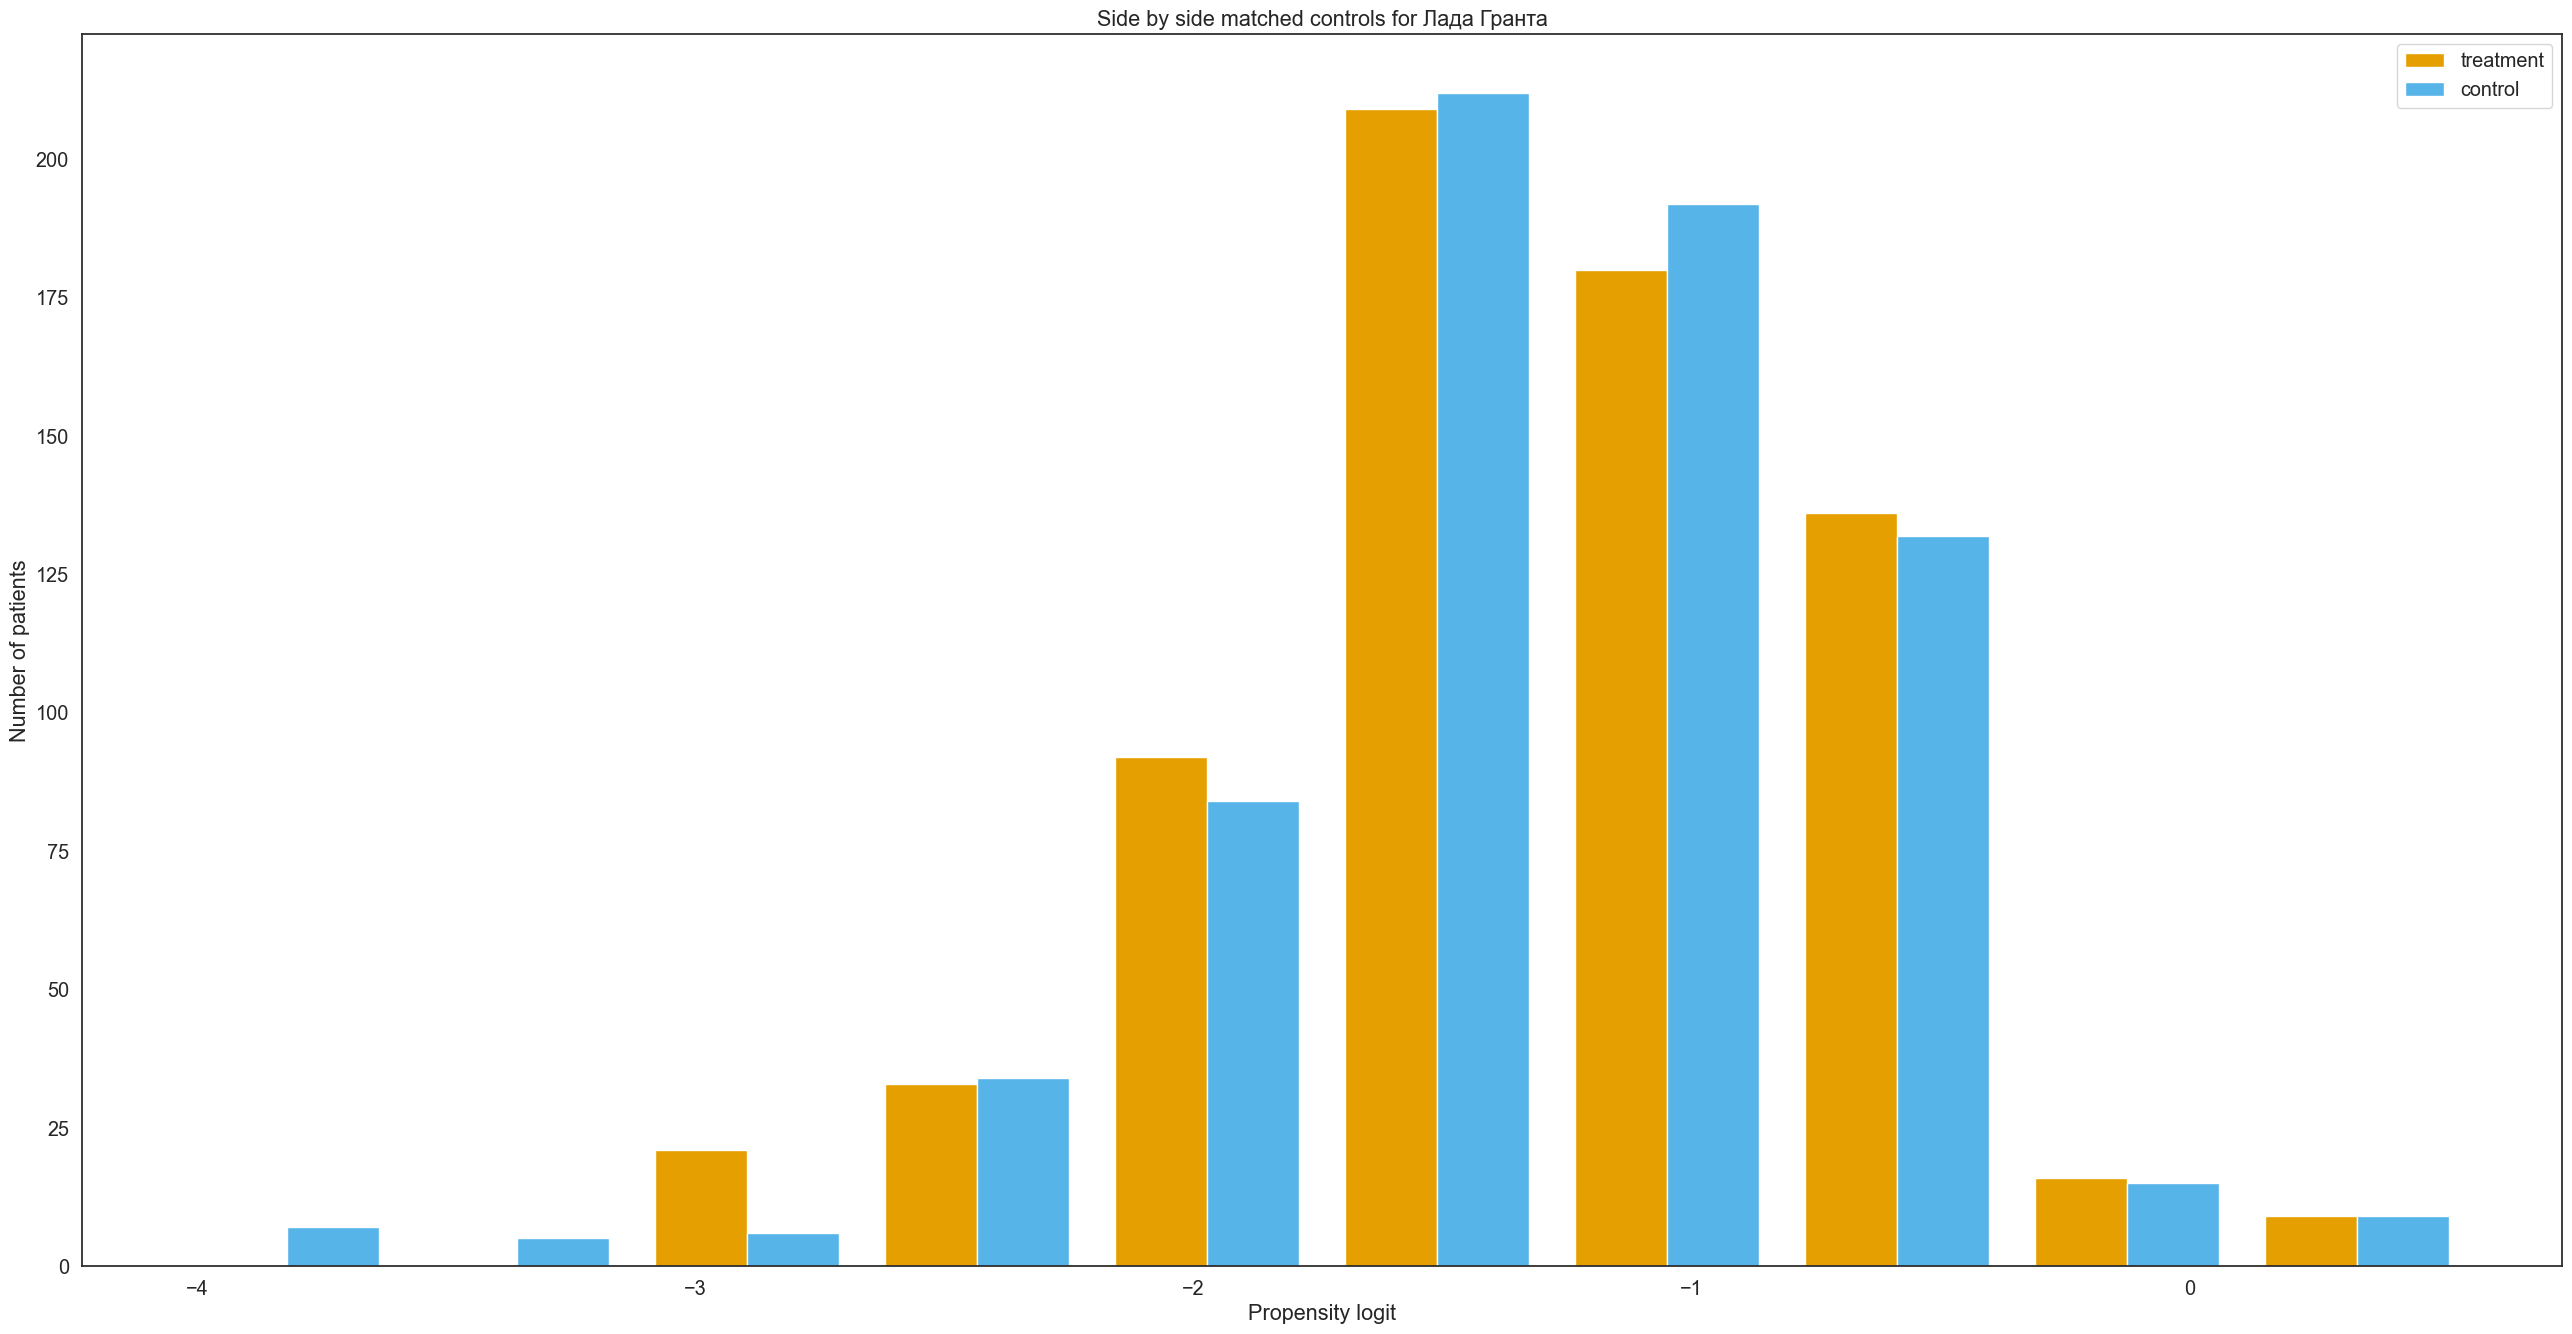

In [63]:
chosen_brand_model = 'Лада Гранта'
print(chosen_brand_model)

psms[chosen_brand_model].plot_match(Title=f'Side by side matched controls for {chosen_brand_model}', 
                           Ylabel='Number of patients', 
                           Xlabel= 'Propensity logit', 
                           names = ['treatment', 'control'], 
                           save=True)

In [64]:
psms[chosen_brand_model].df_matched.head()

,index,state_log_average_invest_per_capita_5years,state_population,state_urban_rate,state_paved_roads_per_capita,state_W,power,state_buses_per_capita,state_log_average_income,gearbox_автомат,gearbox_механика,gearbox_робот,propensity_score,propensity_logit,mileage_new_car,matched_ID
0,128,11.021178,982.6,59.1,9.567830,0.006741,87.0,129,10.251112,0,1,0,0.328356,-0.715631,0,15521.0
1,218,11.021178,982.6,59.1,9.567830,0.006741,98.0,129,10.251112,0,1,0,0.167675,-1.602198,0,71338.0
2,1013,11.332070,4001.6,62.9,11.417394,0.016588,90.0,110,10.392712,0,1,0,0.169800,-1.587048,0,71338.0
3,1039,11.332070,4001.6,62.9,11.417394,0.016588,87.0,110,10.392712,0,1,0,0.214162,-1.300017,0,18858.0
4,1040,11.332070,4001.6,62.9,11.417394,0.016588,87.0,110,10.392712,0,1,0,0.214162,-1.300017,0,18858.0


### NEUTRALIZE THE EFFECT OF MILEAGE

In [65]:
mileage_estimates = estimates.loc['mileage', :].to_dict()
mileage_sqrt_estimates = estimates.loc['mileage_sqrt', :].to_dict()

matching_df = df_shortened[['index', 'log_price', 'mileage', 'mileage_sqrt', 'mileage_new_car', 'price_segment']]
matching_df.loc[matching_df['mileage_new_car'] == 0, 'log_price'] = matching_df\
    .loc[matching_df['mileage_new_car'] == 0, :]\
    .apply(lambda row: row['log_price'] + 
                       row['mileage'] * mileage_estimates[row['price_segment']] +
                       row['mileage_sqrt'] * mileage_sqrt_estimates[row['price_segment']],
           axis=1)

matching_df.head()

,index,log_price,mileage,mileage_sqrt,mileage_new_car,price_segment
0,0,14.647985,0.0,0.000000,1,Средний
1,1,12.498877,10000.0,100.000000,0,Эконом
2,2,15.159654,0.0,0.000000,1,Средний
3,3,12.410410,200.0,14.142136,0,Эконом
4,4,13.744173,10000.0,100.000000,0,Бизнес


### AGGREGATE MATCHED BY CLUSTER AND CALCULATE EFFECTS

In [71]:
match_results = []
for price_segment in matching_df['price_segment'].unique():
    matching_df_segment = matching_df.loc[matching_df['price_segment'] == price_segment]
    
    matching_df_segment = pd.merge(
        matching_df_segment, 
        matched_ids, 
        on = 'index',
        how='left'
    )
    
    matching_df_segment = pd.merge(
        matching_df_segment[['price_segment', 'index', 'log_price', 'mileage_new_car', 'matched_ID']], 
        matching_df_segment[['index', 'log_price', 'mileage_new_car']],
        left_on='matched_ID', 
        right_on='index',
        suffixes=['', '_matched']
    )
    
    matching_df_segment['effect'] = matching_df_segment['log_price'] - matching_df_segment['log_price_matched']
    match_results.append(matching_df_segment.copy())
    
    print(f"Length for label {price_segment}: {matching_df_segment.shape[0]}, ATT={matching_df_segment['effect'].mean().round(3)}")
    

match_results[0].head()

Length for label Средний: 13237, ATT=-0.136
Length for label Эконом: 390, ATT=-0.05
Length for label Бизнес: 2863, ATT=0.093


,price_segment,index,log_price,mileage_new_car,matched_ID,index_matched,log_price_matched,mileage_new_car_matched,effect
0,Средний,12,14.540562,0,74641.0,74641,14.901375,1,-0.360813
1,Средний,428,14.540562,0,74641.0,74641,14.901375,1,-0.360813
2,Средний,910,14.686233,0,74641.0,74641,14.901375,1,-0.215142
3,Средний,2944,14.605245,0,74641.0,74641,14.901375,1,-0.296130
4,Средний,3460,14.390911,0,74641.0,74641,14.901375,1,-0.510464


In [72]:
match_results = pd.concat(match_results)

effects = match_results.groupby('price_segment')['effect'].agg(['mean', 'std'])
effects = (np.exp(effects)* 100).round(1).astype(str) + '%'

match_results['matching number'] = 1
number_of_obs = match_results.groupby('price_segment')['matching number'].count()
result = pd.concat([clust_centers, number_of_obs, effects], axis=1)

result = result.rename({
    'price': 'Ср. цена',
    'engine_liters': 'Ср. объем двигателя',
    'number of obs.': 'Кол-во изначальных наблюдений',
    'matching number': 'Кол-во смэтчинных наблюдений',
    'mean': 'Эффект гарантий',
    'std': 'Ст. откл.'
},
    axis=1)

##### SAVING!

In [78]:
result.to_excel('tables/result.xlsx', index=True)

result

,Ср. цена,Ср. объем двигателя,Кол-во изначальных наблюдений,Кол-во смэтчинных наблюдений,Эффект гарантий,Ст. откл.
Эконом,279983.99,1.64,249444,390,87.36%,"47,44%"
Средний,1354045.75,1.87,416673,13237,107.24%,17.82%
Бизнес,2182329.43,3.64,84061,2863,114.07%,24.13%


In [83]:
chosen_groups = signif_groups\
    .head()\
    .reset_index(drop=True)\
    .rename({
    'brand_model': 'Марка и модель',
    'price_segment': 'Ценовой сегмент',
    0: 'Контрольная группа',
    1: 'Группа воздействия',
    'total': 'Общее число наблюдений'
}, 
    axis=1)

chosen_groups.to_excel('tables/top models.xlsx', index=True)

chosen_groups

,Марка и модель,Ценовой сегмент,Контрольная группа,Группа воздействия,Общее число наблюдений
0,Лада Гранта,Средний,696,5227,5923
1,Hyundai Tucson,Средний,901,1636,2537
2,Kia Sportage,Средний,546,1584,2130
3,Chery Tiggo 7 Pro,Средний,161,1802,1963
4,Hyundai Santa Fe,Средний,424,1305,1729
